# Introduction
In my [previous work](https://www.kaggle.com/code/lazygene/exploring-psychiatric-disorders-eeg-dataset) I explored the dataset and performed multi-class classification. Here, I concentrate on binary classification disorder vs. healthy controls and report feature importance for the best performing models during 10-fold cross-validation.



# Import libraries

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from copy import deepcopy
from tqdm import tqdm
import mne

# Read Data

In [2]:
df = pd.read_csv('../Datasets/EEG_data.csv')
df.head()

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662


Fix typo in specific.disorder:

Obsessive compulsi**t**ve disorder to Obsessive compulsive disorder

# Missing data

Extract separation column between PSD and FC data.

In [3]:
missing = df.isna().sum()
sep_col = missing[missing == df.shape[0]].index[0]
sep_col

'Unnamed: 122'

In [4]:
missing[missing > 0]

education        15
IQ               13
Unnamed: 122    945
dtype: int64

In [5]:
educ_na = df[df['education'].isna()]
iq_na = df[df['IQ'].isna()]
educ_iq_na = pd.concat([educ_na, iq_na]).drop_duplicates()
educ_iq_na

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.00,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
17,18,M,30.00,2013.9.27,NaN,86.0,Addictive disorder,Alcohol use disorder,12.443237,12.503703,...,85.080600,53.533875,62.817411,68.040950,71.834549,48.779049,80.516443,22.049743,76.277261,45.629506
21,22,M,20.00,2014.10.23,NaN,116.0,Addictive disorder,Alcohol use disorder,28.287190,22.412264,...,33.065475,24.351780,18.764173,32.610337,38.451805,20.933501,48.626712,16.258394,40.471735,24.175359
155,156,M,18.00,2013.12.7,NaN,103.0,Addictive disorder,Behavioral addiction disorder,16.548803,19.042179,...,93.825121,79.091595,83.132315,88.900783,87.508591,76.257681,89.811513,62.739950,84.729816,86.322844
173,174,M,23.00,2015.11.14,NaN,113.0,Healthy control,Healthy control,19.050158,23.277470,...,68.005720,54.685472,70.694110,62.676608,67.705314,46.667642,66.673782,29.689482,74.787580,51.039538
269,270,M,25.00,2015.9.23,NaN,85.0,Obsessive compulsive disorder,Obsessive compulsitve disorder,6.186264,7.112847,...,72.743284,63.723838,61.257858,67.473157,77.664778,57.967084,73.898719,59.775191,81.941728,72.195171
270,271,M,34.00,2015.9.21,NaN,120.0,Obsessive compulsive disorder,Obsessive compulsitve disorder,12.784872,15.922964,...,72.409132,49.265064,41.222401,68.010480,72.429188,26.188907,68.653874,18.072318,63.285321,41.822238
279,280,M,35.00,2016.6.2,NaN,NaN,Obsessive compulsive disorder,Obsessive compulsitve disorder,21.524573,22.227615,...,90.934877,93.568209,94.185299,92.271775,96.445879,91.470862,96.851513,92.296182,96.209585,96.660561
280,281,M,37.00,2016.6.27,NaN,110.0,Obsessive compulsive disorder,Obsessive compulsitve disorder,11.971083,11.374465,...,91.150863,78.359575,64.861521,74.389105,89.863923,50.322649,75.469583,49.440177,84.022887,69.921675
281,282,M,22.00,2016.6.30,NaN,107.0,Obsessive compulsive disorder,Obsessive compulsitve disorder,12.516343,10.136242,...,96.419647,77.360976,95.156801,96.105427,87.746498,94.760227,97.579921,81.495805,86.770154,98.121870


In [6]:
drop_md = educ_iq_na['main.disorder'].value_counts().sort_index()
all_md = df['main.disorder'].value_counts().sort_index()[drop_md.index]
pd.concat([all_md, drop_md/all_md * 100], axis=1).set_axis(['all_data', 'na_percentage'], axis=1).sort_values('na_percentage', ascending=False)

,all_data,na_percentage
main.disorder,,
Obsessive compulsive disorder,46,13.043478
Addictive disorder,186,4.301075
Trauma and stress related disorder,128,3.906250
Healthy control,95,2.105263
Mood disorder,266,1.503759
Anxiety disorder,107,0.934579


We will loose too much data (13%) on patients with obsessive compulsive disorder, which is one of the smallest groups already. So we should consider filling missing data.  
Our options to fill them are:
- special value
- mean/median value
- imputation

We will fill missing data with **median values**.

In [7]:
display(df[['education', 'IQ']].agg(['mean', 'median']))
imputer = SimpleImputer(strategy='median')

,education,IQ
mean,13.43871,101.580472
median,13.00000,102.000000


# Pre-processing
To prepare data for classification we need:

1. Drop separation column, id colums (no. and eeg.date)
1. Encode target (main.disorder and specific.disorder) and categorical (sex) varables 
1. Drop target variables from features
1. Fill missing data in education and IQ columns
1. Apply log transformation to Age, PSD and FC features
1. Separate features and targets into separate subset for binary classification (disorder vs. healthy control)
1. Scale features

In [8]:
ptsd = df[df['specific.disorder'] == 'Posttraumatic stress disorder']
hc = df[df['specific.disorder'] == 'Healthy control'].sample(n=52, random_state=42)
data = pd.concat([ptsd, hc])
X = data

X = X.drop([sep_col, 'no.', 'eeg.date','main.disorder'], axis=1)

target_col = ['specific.disorder']
cat_col = ['sex']
sex_ord = df['sex'].unique()

# encoder for targets and sex
enc = OrdinalEncoder(categories=[sex_ord])
X[cat_col] = enc.fit_transform(X[cat_col])
X['specific.disorder'] = X['specific.disorder'].map({'Posttraumatic stress disorder': 1, 'Healthy control': 0})
target = X['specific.disorder']
X.drop(target_col, axis=1, inplace=True)

# fill missing data
mv_cols = ['education', 'IQ']
X[mv_cols] = imputer.fit_transform(X[mv_cols])

# numerical columns for log-transformation
logtrans_cols = X.drop(['sex', 'education', 'IQ'], axis=1).columns
X[logtrans_cols] = X[logtrans_cols].apply(pd.to_numeric, errors='coerce')


In [9]:
X, target

(     sex    age  education     IQ  AB.A.delta.a.FP1  AB.A.delta.b.FP2  \
 297  1.0  36.62       12.0   99.0         17.603385         17.243334   
 309  1.0  55.21       16.0  120.0         21.714048         19.579805   
 310  1.0  26.93       16.0  116.0         13.371076         14.028142   
 315  0.0  26.71       17.0  137.0         30.473244         13.954586   
 318  1.0  23.45       12.0   89.0         18.488575         19.603144   
 ..   ...    ...        ...    ...               ...               ...   
 137  1.0  29.04       16.0  114.0         22.737005         23.110192   
 116  1.0  25.65       18.0  118.0         20.081892         17.928614   
 130  1.0  29.86       20.0  113.0         46.306229         47.379694   
 184  0.0  27.00       18.0  130.0         22.152399         22.698280   
 121  1.0  23.66       17.0  130.0         37.450821         54.405099   
 
      AB.A.delta.c.F7  AB.A.delta.d.F3  AB.A.delta.e.Fz  AB.A.delta.f.F4  ...  \
 297        11.729942        

# Model selection
What algorithm will work best?  
We will use cross-validation with 10 folds to choose the best algorithm for classification for each disorder.

Algorithms to consider:
- Logistic Regression, ElasticNet
- SVM, Linear Kernel (to have access to feature importance)
- Random Forest
- XGBoost
- LightGBM
- CatBoost

In [10]:
def lists_to_dict (keys, items):
    return {key: item for key,item in zip(keys, items)}

# models names
model_names = ['EN', 'SVM', 'RF', 'XGB', 'LGBM', 'CatBoost']
# param grids for gridsearch
param_grids = [
    {
        'l1_ratio': np.linspace(0, 1, 5),
        'C': [0.5, 1, 5, 10]
    },
    {
        'C': [0.5, 1, 5, 10]
    },
    {
        'n_estimators': [100, 300, 500],
        'max_depth': [1, 3, 6, None]
    },
    {
        'n_estimators': [100, 300, 500],
        'subsample': [0.3, 0.5, 1],
        'max_depth': [1, 3, 6, None]
    },
    {
        'n_estimators': [100, 300, 500],
        'subsample': [0.3, 0.5, 1],
        'max_depth': [1, 3, 6, None]
    },
    {
        'n_estimators': [100, 300, 500],
        'max_depth': [1, 3, 6, None], 
        
    }  
]
param_grids = lists_to_dict(model_names, param_grids)

# models for gridsearch
models = [
    LogisticRegression(penalty='elasticnet', solver='saga'),
    SVC(kernel='linear', random_state=77),
    RandomForestClassifier(random_state=77),
    XGBClassifier(),#tree_method='gpu_hist'),
    LGBMClassifier(random_state=77), #device='gpu'),
    CatBoostClassifier(random_seed=77,logging_level='Silent')#,task_type='GPU')
]
models = lists_to_dict(model_names, models)

In [11]:
def n_best (gs_result, n=1):
    """Returns nth best estimator parameters, mean score and std of it"""
    ind = np.where(gs_result['rank_test_score'] == n)[0][0]
    mean = gs_result["mean_test_score"][ind]
    std = gs_result["std_test_score"][ind]
    params = gs_result["params"][ind]
    return params, mean, std

def cache_mkdir(cache, directory, root_dir='.'):
    """Create directory and return path to it"""
    directory = directory.replace(' ', '_')
    path = os.path.join(root_dir, directory)
    if cache and not os.path.exists(path):
        os.makedirs(path)
    return path

def read_cache(cache, path, silent=False):
    """Read from cache file"""
    result = None
    if cache and os.path.exists(path):
        with open(path, 'rb') as file:
            if not silent:
                print(f'Extracted from cache ({path})')
            result = pickle.load(file)
    return result

def write_cache(cache, obj, path):
    """Write to cache"""
    if cache:
        with open(path, 'wb') as file:
            pickle.dump(obj, file) 

In [12]:
def grid_search(disorder, model, params, X, Y, random_seed=None, cache=True, cache_dir='grid_search', feature_list=None, silent=False):
    """
    Performs a grid search for hyperparameter tuning on a single disorder.

    Parameters:
    - disorder (str): Name of the disorder for caching purposes.
    - model (estimator): The model to tune.
    - params (dict): Hyperparameters for grid search.
    - X (DataFrame): Feature set for the given disorder.
    - Y (Series): Target labels for the given disorder.
    - random_seed (int, optional): Random seed for reproducibility.
    - cache (bool, optional): Whether to use caching to save results.
    - cache_dir (str, optional): Directory to store cache files.
    - feature_list (list, optional): List of features to be used.
    - silent (bool, optional): If True, suppress cache read notifications.

    Returns:
    - dict: A dictionary containing the best hyperparameters, mean score, standard deviation, and cv results.
    """

    # Set feature list if None
    if feature_list is None:
        feature_list = X.columns

    # Create cache directory if needed
    cache_mkdir(cache, cache_dir)

    # Get and create (if needed) a disorder cache directory
    disorder_folder = cache_mkdir(cache, disorder, cache_dir)

    # Get cache file path
    cache_file = os.path.join(disorder_folder, model.__class__.__name__)

    # Read file from cache
    result = read_cache(cache, cache_file, silent)
    if result is None:
        result = {}
        result['Model'] = model.__class__.__name__

        # Set seed
        if random_seed is not None:
            np.random.seed(random_seed)

        # Scale features
        scaler = StandardScaler()
        x = scaler.fit_transform(X[feature_list])

        # Perform grid search
        gs = GridSearchCV(model, params, cv=10, scoring='roc_auc', n_jobs=-1, verbose=1).fit(x, Y)

        # Get best estimator parameters, cross-validation mean score, and score std
        result['Params'], result['Mean_score'], result['Std_score'] = n_best(gs.cv_results_)

        # Save cv_results_
        result['cv_result'] = deepcopy(gs.cv_results_)

        # Cache results
        write_cache(cache, result, cache_file)

    return result

In [13]:
import warnings
warnings.filterwarnings('ignore')

## Specific disorder

In [14]:
X = pd.DataFrame(X) 
Y = pd.Series(target)

In [15]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Helper function to create dictionaries
def lists_to_dict(keys, items):
    return {key: item for key, item in zip(keys, items)}

# Models names
model_names = ['EN', 'SVM', 'RF', 'XGB', 'LGBM', 'CatBoost']

# Parameter grids for grid search
param_grids = [
    {
        'l1_ratio': np.linspace(0, 1, 5),
        'C': [0.5, 1, 5, 10]
    },
    {
        'C': [0.5, 1, 5, 10]
    },
    {
        'n_estimators': [100, 300, 500],
        'max_depth': [1, 3, 6, None]
    },
    {
        'n_estimators': [100, 300, 500],
        'subsample': [0.3, 0.5, 1],
        'max_depth': [1, 3, 6, None]
    },
    {
        'n_estimators': [100, 300, 500],
        'subsample': [0.3, 0.5, 1],
        'max_depth': [1, 3, 6, None]
    },
    {
        'n_estimators': [100, 300, 500],
        'max_depth': [1, 3, 6, None]
    }  
]
param_grids = lists_to_dict(model_names, param_grids)

# Models for grid search
models = [
    LogisticRegression(penalty='elasticnet', solver='saga'),
    SVC(kernel='linear', random_state=77),
    RandomForestClassifier(random_state=77),
    XGBClassifier(),
    LGBMClassifier(random_state=77),
    CatBoostClassifier(random_seed=77, logging_level='Silent')
]
models = lists_to_dict(model_names, models)

result={}
# Iterate over models
for name, model in models.items():
    param_grid = param_grids.get(name, {})
    result.update({f"{name}": grid_search(
        disorder='Posttraumatic stress disorder',
        model=model,
        params=param_grid,
        X=X,
        Y=target,
        random_seed=42
    )} )

Extracted from cache (grid_search/Posttraumatic_stress_disorder/LogisticRegression)
Extracted from cache (grid_search/Posttraumatic_stress_disorder/SVC)
Extracted from cache (grid_search/Posttraumatic_stress_disorder/RandomForestClassifier)
Extracted from cache (grid_search/Posttraumatic_stress_disorder/XGBClassifier)
Extracted from cache (grid_search/Posttraumatic_stress_disorder/LGBMClassifier)
Extracted from cache (grid_search/Posttraumatic_stress_disorder/CatBoostClassifier)


In [16]:
sd_results = pd.DataFrame(result)
sd_results

,EN,SVM,RF,XGB,LGBM,CatBoost
Model,LogisticRegression,SVC,RandomForestClassifier,XGBClassifier,LGBMClassifier,CatBoostClassifier
Params,"{'C': 0.5, 'l1_ratio': 1.0}",{'C': 0.5},"{'max_depth': 3, 'n_estimators': 100}","{'max_depth': 3, 'n_estimators': 100, 'subsamp...","{'max_depth': 3, 'n_estimators': 100, 'subsamp...","{'max_depth': 6, 'n_estimators': 300}"
Mean_score,0.826,0.701333,0.782667,0.901333,0.89,0.908667
Std_score,0.119199,0.174962,0.155755,0.078304,0.08518,0.075663
cv_result,"{'mean_fit_time': [0.12471399307250977, 0.2721...","{'mean_fit_time': [0.009084439277648926, 0.010...","{'mean_fit_time': [0.13464815616607667, 0.3618...","{'mean_fit_time': [0.24012186527252197, 0.2220...","{'mean_fit_time': [0.4563059568405151, 0.55633...","{'mean_fit_time': [1.2200778007507325, 2.74857..."


## Conclusions
All algorithms showed good performance above chance (0.5). Severe disorders, like Schizophrenia, and specific disorder tend show higher scores. The worst result is seen for Obsessive compulsive disorder, it can be explained by poor quality of data (high percentage of missing values and small sample size). 

We will look into PSD and FC feature importance for the best performing estimator within disorder:

- **Addictive disorder**: LightGBM
- **Trauma and stress related disorder**: LightGBM
- **Mood disorder**: CatBoost
- **Obsessive compulsive disorder**: LightGBM
- **Schizophrenia**: LightGBM
- **Anxiety disorder**: LogisticRegression
- **Alcohol use disorder**: LogisticRegression
- **Acute stress disorder**: CatBoost
- **Depressive disorder**: LightGBM
- **Behavioral addiction disorder**: LightGBM
- **Panic disorder**: LogisticRegression
- **Social anxiety disorder**: CatBoost
- **Posttraumatic stress disorder**: CatBoost
- **Adjustment disorder**: CatBoost
- **Bipolar disorder**: CatBoost

In [17]:
chosen_models = {
    'Addictive disorder': 'LGBM',
    'Trauma and stress related disorder': 'LGBM',
    'Mood disorder': 'CatBoost',
    'Obsessive compulsive disorder': 'LGBM',
    'Schizophrenia': 'LGBM',
    'Anxiety disorder': 'EN',
    'Alcohol use disorder': 'EN',
    'Acute stress disorder': 'CatBoost',
    'Depressive disorder': 'LGBM',
    'Behavioral addiction disorder': 'LGBM',
    'Panic disorder': 'EN',
    'Social anxiety disorder': 'CatBoost',
    'Posttraumatic stress disorder': 'CatBoost',
    'Adjustment disorder': 'CatBoost',
    'Bipolar disorder': 'CatBoost'
}

# Feature importance
To report feature importance, we will use selected best models and hyper-parameters. We will perform 10-fold cross-validation and record feature importance for each run. Next, sum, mean, and *survival rate* will be calculated. *Survival rate* is what percentage of times feature had value above threshold (e.g. zero). 

In [18]:
def get_row(result, disorder, algorithm):
    return result[(result['disorder'] == disorder) & (result['algorithm'] == algorithm)].squeeze()

def get_model(row, models=models):
    model = deepcopy(models[row['algorithm']])
    model.set_params(**row['params'])
    return model

def cv_fi(x, y, model, random_state=None, n=10, debug=True):

    feature_names = x.columns
    cv_results = dict()
    # split counter
    i = 1
    # KFold splitting
    skf = StratifiedKFold(n_splits=n, shuffle=True, random_state=random_state)
    
    for train_index, test_index in skf.split(x, y):
        # get train x and y
        x_train, y_train = x.iloc[train_index], y.iloc[train_index]
        # scale features
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        # fit model
        model.fit(x_train, y_train)
        # save feature importance
        cv_results[f'split{i}_fi'] = model.feature_importances_
        # debug
        
        if debug:
            # get test x and y
            x_test, y_test = x.iloc[test_index], y.iloc[test_index]
            # scale
            x_test = scaler.transform(x_test)
            # predict
            y_pred = model.predict(x_test)
            # show results
            print(f'Split {i} report')
            print(classification_report(y_test, y_pred))
        # iterate split counter
        i += 1
    result = pd.DataFrame(cv_results, index=feature_names)
    return (result)

def psd_coh(name):
    splt = name.split(sep='.')
    
    if len(splt) < 5:
        result = name
    elif len(splt)==5:
        result = f'{splt[2]} PSD'
    else:
        result = f'{splt[2]} FC'
    return result

def summary_fi_table(table, threshold=0):
    
    # rename index
    table.index.name = 'feature'
    # reset index and convert to long format
    table = table.reset_index().melt(id_vars='feature', var_name='split_id', value_name='importance')
    
    # negative importance?
    n_imp = (table['importance'] < 0).any()
    
    # if importance is above the threshold than survived=1, 0 othervise
    table['survived'] = (table['importance'].abs() > threshold)
    
    # feature category
    table['feature_cat'] = table['feature'].apply(psd_coh)
    
    
    # summary table
    result = table.groupby(['feature_cat', 'feature']).agg({
        'importance': ['sum', 'mean', 'median'],
        'survived': 'mean'
    })
    return result

def flatten_columns(table):
    """Flatten column indices"""
    table.columns = ['_'.join(col) for col in table.columns.values]
    return table

def top_n(table, n=15, col='importance_sum', survival_thres=0.7, abs_based=True):
    """Report n top important features"""
    if abs_based:
        table['abs_col'] = table[col].abs()
        col='abs_col'
    result = table[table['survived_mean'] >= survival_thres].sort_values(col, ascending=False).iloc[:n]
    return result


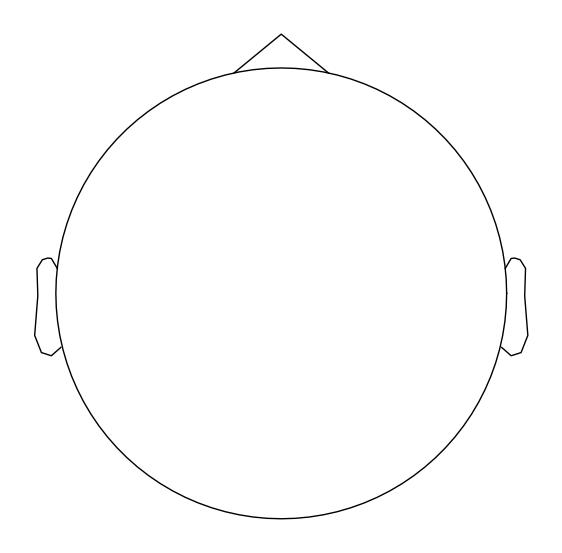

In [19]:
# Generate head picture for visualisations
mtg_chan = {'FP1': [-0.03, 0.08, 0],
 'FP2': [0.03, 0.08, 0],
 'F7': [-0.073, 0.047, 0],
 'F3': [-0.04, 0.041, 0],
 'Fz': [0, 0.038, 0],
 'F4': [0.04, 0.041, 0],
 'F8': [0.073, 0.047, 0],
 'T3': [-0.085, 0, 0],
 'C3': [-0.045, 0, 0],
 'Cz': [0, 0, 0],
 'C4': [0.045, 0, 0],
 'T4': [0.085, 0, 0],
 'T5': [-0.073, -0.047, 0],
 'P3': [-0.04, -0.041, 0],
 'Pz': [0, -0.038, 0],
 'P4': [0.04, -0.041, 0],
 'T6': [0.07, -0.047, 0],
 'O1': [-0.03, -0.08, 0],
 'O2': [0.03, -0.08, 0]}

info = mne.create_info(list(mtg_chan.keys()), 500, ch_types='eeg')
montage = mne.channels.make_dig_montage(mtg_chan)
info.set_montage(montage)
fig, ax = plt.subplots(figsize=(7,7))
mne.viz.plot_sensors(info, ch_type='eeg', pointsize=0, axes=ax)
fig.savefig('head.png', bbox_inches='tight', transparent=True)
plt.style.use('default')

In [20]:
def barchart(table, x, heights, color=None, ax=None, palette=None, orient='h', xlab=None, ylab=None):
    if ax is None:
        fig, ax = plt.subplots()
    if orient == 'v':
        barfunc = ax.bar
        ax.yaxis.grid(True)
        ax.xaxis.grid(False)
        ax.set_xlabel(xlab if xlab else x)
        ax.set_ylabel(ylab if ylab else heights)
    else:
        barfunc = ax.barh
        ax.xaxis.grid(True)
        ax.yaxis.grid(False)
        ax.set_ylabel(xlab if xlab else x)
        ax.set_xlabel(ylab if ylab else heights)
    if color is not None:
        # Handle colors using the feature categories from the palette
        colors = [palette.get(cat, 'grey') for cat in table['feature_cat']]
        patches = [mpatches.Patch(color=palette[c], label=c) for c in set(table['feature_cat']) if c in palette]
        ax.legend(handles=patches, loc='best')
    else:
        colors = None
    barfunc(table[x], table[heights], color=colors)
    return ax

# Ensure consistent coloration
feature_category = [
    'delta PSD',
    'delta FC',
    'theta PSD',
    'theta FC',
    'alpha PSD',
    'alpha FC',
    'beta PSD',
    'beta FC',
    'highbeta PSD',
    'highbeta FC',
    'gamma PSD',
    'gamma FC']
cmap = plt.get_cmap('tab20')
palette = {feature_category[i]: cmap.colors[i] for i in range(len(feature_category))}

# Position of channels on EEG map
chs = {
    'FP1': [-0.2625, 0.6300000000000001],
    'FP2': [0.2625, 0.6300000000000001],
    'F7': [-0.6387499999999999, 0.34125],
    'F3': [-0.35000000000000003, 0.28875],
    'Fz': [0.0, 0.2625],
    'F4': [0.35000000000000003, 0.28875],
    'F8': [0.6387499999999999, 0.34125],
    'T3': [-0.74375, -0.07],
    'C3': [-0.39375, -0.07],
    'Cz': [0.0, -0.07],
    'C4': [0.39375, -0.07],
    'T4': [0.74375, -0.07],
    'T5': [-0.6387499999999999, -0.48125],
    'P3': [-0.35000000000000003, -0.42875],
    'Pz': [0.0, -0.4025],
    'P4': [0.35000000000000003, -0.42875],
    'T6': [0.6125, -0.48125],
    'O1': [-0.2625, -0.77],
    'O2': [0.2625, -0.77]}
channels = pd.DataFrame(chs).transpose()

sns.set_style('whitegrid')

def reformat_name(name):
    '''
    reformat from XX.X.band.x.channel to band.channel or 
    COH.X.band.x.channel1.x.channel2 to COH.band.channel1.channel2
    '''
    splitted = name.split(sep='.')
    if len(splitted) < 5:
        return name
    if splitted[0] != 'COH':
        result = f'{splitted[2]}.{splitted[4]}'
    else:
        result = f'{splitted[0]}.{splitted[2]}.{splitted[4]}.{splitted[6]}'
    return result

def extract_channel(feature):
    """
    Extract channels from QEEG feature names
    Examples:
    delta.T4 -> T4
    COH.delta.Cz.T4 -> [Cz, T4]
    """
    feature=reformat_name(feature)
    split = feature.split(sep='.')
    if split[0] == 'COH':
        result = split[4:]
    else:
        result = [split[-1]]
    return result

def get_channels(features):
    """
    Get channels from comma separated feature names.
    Examples:
    delta.T4, COH.delta.Cz.T4 -> [T4, [Cz, T4]]    
    """
    split = features.split(sep=',')
    result = [extract_channel(ftr) for ftr in split]
    return np.concatenate(result)

def get_coordinates(channels_arr):
    """Extract x and y coordinates by channel names"""
    valid_channels = [ch for ch in channels_arr if ch in channels.index]
    selected = channels.loc[valid_channels]
    x, y = selected.iloc[:, 0], selected.iloc[:, 1]
    return x, y

def fi_viz(table, feature, feature_cat, importance, palette, figure=None, cat=True):
    if figure is None:
        figure = plt.figure()
    if cat:
        axes = figure.subplots(1, 2)
        cat_fi = table.groupby(feature_cat)[importance].sum().reset_index().sort_values(importance, ascending=False)
        barchart(cat_fi, feature_cat, importance, feature_cat, axes[1], palette, xlab='importance', ylab='feature category')
    else:
        axes = figure.subplots()
        axes = [axes]        
    barchart(table, feature, importance, feature_cat, axes[0], palette, xlab='importance')        
    return figure


def fi_viz_eeg(table,  palette, feature='feature', feature_cat='feature_cat', figure=None, ax=None, separate=True, img_path='head.png'):
    # Read backgroud image
    im = plt.imread('head.png')
    if ax is not None:
        separate=False
    elif figure is None:
        figure = plt.figure()
    if separate:
        axes = figure.subplots(1, 2)
        ax_psd = axes[0]
        ax_coh = axes[1]
        axes[0].set_title('Power Spectral Density (PSD)')
        axes[1].set_title('Functional Connectivity (FC)')
    else:
        if ax is None:
            axes = figure.subplots()
        else:
            axes = ax
        ax_psd = axes
        ax_coh = axes
        axes = [axes]
    # Plot 
    ftrcat_channels  = table.groupby(feature_cat)[feature].agg(','.join).transform(get_channels)
    for ftr_cat, channels_arr in ftrcat_channels.items():
        color = palette[ftr_cat]
        if 'PSD' in ftr_cat:
            x, y = get_coordinates(channels_arr)
            ax_psd.scatter(x, y, c=[color], s=plt.rcParams['lines.markersize'] ** 3.5, label=ftr_cat)
        else:
            for i, arr in enumerate(channels_arr):
                x, y = get_coordinates(arr)
                if i == 0:
                    lab = ftr_cat
                else:
                    lab = None
                ax_coh.plot(x, y, c=color, linewidth=12, label=lab)
                
    for txt in channels.index:
        for ax in axes:
            text = ax.text(channels.loc[txt, 0], channels.loc[txt, 1], txt, color='white', fontweight='extra bold',  
                           horizontalalignment='center', verticalalignment='center')
            text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])

    for ax in axes:
        ax.imshow(im, extent=[-1, 1, -1, 1])
        ax.axis('off')
        ax.margins(x=0, y=0)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labelspacing=1.5, frameon=False)

def report_fi(result, disorder, col='importance_sum', survival_thres=0.7, palette=palette, root_dir=None):  
    # Extract top n features
    table = top_n(flatten_columns(summary_fi_table(result)), survival_thres=survival_thres).reset_index()

    # Recreate palette to include only relevant colors
    unq_cat = table['feature_cat'].unique()
    palette = {key: item for key, item in palette.items() if key in unq_cat}

    # Barchart feature and category importance 
    fig1 = plt.figure(tight_layout=True, figsize=(15, 5))
    fig1.suptitle(disorder)
    fi_viz(table, 'feature', 'feature_cat', col, palette, fig1)
    fig1.tight_layout()

    # Plot feature importance on EEG map
    fig2 = plt.figure(tight_layout=True, figsize=(15, 7))
    fi_viz_eeg(table, figure=fig2, palette=palette)
    fig2.tight_layout()

    # Save figures if root_dir is provided
    if root_dir:
        fig1.savefig(f"{root_dir}/barchart.png")
        fig2.savefig(f"{root_dir}/eeg_map.png")

    return fig1, fig2



In [21]:
def barchart(table, x, heights, color=None, ax=None, palette=None, orient='h', xlab=None, ylab=None):
    if ax is None:
        fig, ax = plt.subplots()
    if orient == 'v':
        barfunc = ax.bar
        ax.yaxis.grid(True)
        ax.xaxis.grid(False)
        ax.set_xlabel(xlab if xlab else x)
        ax.set_ylabel(ylab if ylab else heights)
    else:
        barfunc = ax.barh
        ax.xaxis.grid(True)
        ax.yaxis.grid(False)
        ax.set_ylabel(xlab if xlab else x)
        ax.set_xlabel(ylab if ylab else heights)
    if color is not None:
        # Handle colors using the feature categories from the palette
        colors = [palette.get(cat, 'grey') for cat in table['feature_cat']]
        patches = [mpatches.Patch(color=palette.get(c, 'grey'), label=c) for c in set(table['feature_cat'])]
        ax.legend(handles=patches, loc='best')
    else:
        colors = None
    barfunc(table[x], table[heights], color=colors)
    return ax

# Ensure consistent coloration
feature_category = [
    'delta PSD',
    'delta FC',
    'theta PSD',
    'theta FC',
    'alpha PSD',
    'alpha FC',
    'beta PSD',
    'beta FC',
    'highbeta PSD',
    'highbeta FC',
    'gamma PSD',
    'gamma FC']
cmap = plt.get_cmap('tab20')
palette = {feature_category[i]: cmap.colors[i] for i in range(len(feature_category))}

# Position of channels on EEG map
chs = {
    'FP1': [-0.2625, 0.6300000000000001],
    'FP2': [0.2625, 0.6300000000000001],
    'F7': [-0.6387499999999999, 0.34125],
    'F3': [-0.35000000000000003, 0.28875],
    'Fz': [0.0, 0.2625],
    'F4': [0.35000000000000003, 0.28875],
    'F8': [0.6387499999999999, 0.34125],
    'T3': [-0.74375, -0.07],
    'C3': [-0.39375, -0.07],
    'Cz': [0.0, -0.07],
    'C4': [0.39375, -0.07],
    'T4': [0.74375, -0.07],
    'T5': [-0.6387499999999999, -0.48125],
    'P3': [-0.35000000000000003, -0.42875],
    'Pz': [0.0, -0.4025],
    'P4': [0.35000000000000003, -0.42875],
    'T6': [0.6125, -0.48125],
    'O1': [-0.2625, -0.77],
    'O2': [0.2625, -0.77]}
channels = pd.DataFrame(chs).transpose()

sns.set_style('whitegrid')

def reformat_name(name):
    '''
    Reformat from XX.X.band.x.channel to band.channel or 
    COH.X.band.x.channel1.x.channel2 to COH.band.channel1.channel2
    '''
    splitted = name.split(sep='.')
    if len(splitted) < 5:
        return name
    if splitted[0] != 'COH':
        result = f'{splitted[2]}.{splitted[4]}'
    else:
        result = f'{splitted[0]}.{splitted[2]}.{splitted[4]}.{splitted[6]}'
    return result

def extract_channel(feature):
    """
    Extract channels from QEEG feature names
    Examples:
    delta.T4 -> T4
    COH.delta.Cz.T4 -> [Cz, T4]
    """
    feature = reformat_name(feature)
    split = feature.split(sep='.')
    if split[0] == 'COH':
        result = split[2:4]
    else:
        result = [split[-1]]
    return result

def get_channels(features):
    """
    Get channels from comma separated feature names.
    Examples:
    delta.T4, COH.delta.Cz.T4 -> [T4, [Cz, T4]]    
    """
    split = features.split(sep=',')
    result = [extract_channel(ftr) for ftr in split]
    return np.concatenate(result)

def get_coordinates(channels_arr):
    """Extract x and y coordinates by channel names"""
    valid_channels = [ch for ch in channels_arr if ch in channels.index]
    selected = channels.loc[valid_channels]
    x, y = selected.iloc[:, 0], selected.iloc[:, 1]
    return x, y

def fi_viz(table, feature, feature_cat, importance, palette, figure=None, cat=True):
    if figure is None:
        figure = plt.figure()
    if cat:
        axes = figure.subplots(1, 2)
        cat_fi = table.groupby(feature_cat)[importance].sum().reset_index().sort_values(importance, ascending=False)
        barchart(cat_fi, feature_cat, importance, palette=palette, ax=axes[1], xlab='importance', ylab='feature category')
    else:
        axes = figure.subplots()
        axes = [axes]        
    barchart(table, feature, importance, palette=palette, ax=axes[0], xlab='importance')
    return figure

def fi_viz_eeg(table, palette, feature='feature', feature_cat='feature_cat', figure=None, ax=None, separate=True, img_path='head.png'):
    # Read background image
    try:
        im = plt.imread(img_path)
    except FileNotFoundError:
        im = None
        print(f"Warning: Background image '{img_path}' not found. Proceeding without it.")
    if ax is not None:
        separate = False
    elif figure is None:
        figure = plt.figure()
    if separate:
        axes = figure.subplots(1, 2)
        ax_psd = axes[0]
        ax_coh = axes[1]
        axes[0].set_title('Power Spectral Density (PSD)')
        axes[1].set_title('Functional Connectivity (FC)')
    else:
        if ax is None:
            axes = figure.subplots()
        else:
            axes = ax
        ax_psd = axes
        ax_coh = axes
        axes = [axes]
    
    # Plot 
    ftrcat_channels = table.groupby(feature_cat)[feature].agg(','.join).transform(get_channels)
    for ftr_cat, channels_arr in ftrcat_channels.items():
        if ftr_cat not in palette:
            continue  # Skip feature categories that are not in the palette
        color = palette[ftr_cat]
        if 'PSD' in ftr_cat:
            x, y = get_coordinates(channels_arr)
            ax_psd.scatter(x, y, c=[color], s=plt.rcParams['lines.markersize'] ** 3.5, label=ftr_cat)
        else:
            for i, arr in enumerate(channels_arr):
                x, y = get_coordinates(arr)
                lab = ftr_cat if i == 0 else None
                ax_coh.plot(x, y, c=color, linewidth=12, label=lab)
            
    for txt in channels.index:
        for ax in axes:
            text = ax.text(channels.loc[txt, 0], channels.loc[txt, 1], txt, color='white', fontweight='extra bold',  
                           horizontalalignment='center', verticalalignment='center')
            text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])

    for ax in axes:
        if im is not None:
            ax.imshow(im, extent=[-1, 1, -1, 1])
        ax.axis('off')
        ax.margins(x=0, y=0)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        # Put a legend to the right of the current axis
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), labelspacing=1.5, frameon=False)

def report_fi(result, disorder, col='importance_sum', survival_thres=0.7, palette=palette, root_dir=None):  
    # Extract top n features
    table = top_n(flatten_columns(summary_fi_table(result)), survival_thres=survival_thres).reset_index()

    # Recreate palette to include only relevant colors
    unq_cat = table['feature_cat'].unique()
    palette = {key: item for key, item in palette.items() if key in unq_cat}

    # Barchart feature and category importance 
    fig1 = plt.figure(tight_layout=True, figsize=(15, 5))
    fig1.suptitle(disorder)
    fi_viz(table, 'feature', 'feature_cat', col, palette, fig1)
    fig1.tight_layout()

    # Plot feature importance on EEG map
    fig2 = plt.figure(tight_layout=True, figsize=(15, 7))
    fi_viz_eeg(table, figure=fig2, palette=palette)
    fig2


In [22]:
!rm -rf viz

In [23]:
CatBoost=CatBoostClassifier(random_seed=77, logging_level='Silent')
cache=True
cache_dir='cv_fi'
exclude=['sex', 'age', 'education', 'IQ']

cache_mkdir(cache, cache_dir)
cache_file = os.path.join(cache_dir, 'result')

fi = read_cache(cache, cache_file)
if fi is None:
    fi = cv_fi(X,Y,CatBoost)
    write_cache(cache, fi, cache_file)
fi = fi[~fi.index.isin(exclude)]
result=fi

result

Extracted from cache (cv_fi/result)


,split1_fi,split2_fi,split3_fi,split4_fi,split5_fi,split6_fi,split7_fi,split8_fi,split9_fi,split10_fi
AB.A.delta.a.FP1,0.041497,0.050451,0.031934,0.016051,0.035774,0.011956,0.007633,0.046466,0.054553,0.053308
AB.A.delta.b.FP2,0.090171,0.005771,0.121313,0.109282,0.049471,0.070716,0.055776,0.076218,0.075044,0.045541
AB.A.delta.c.F7,0.079956,0.088065,0.078682,0.065594,0.190007,0.062749,0.092443,0.057720,0.102581,0.049680
AB.A.delta.d.F3,0.037381,0.177218,0.064518,0.172925,0.170116,0.194606,0.122551,0.179794,0.070993,0.171911
AB.A.delta.e.Fz,0.195998,0.071015,0.084145,0.109915,0.039621,0.067382,0.029985,0.084351,0.069122,0.049471
...,...,...,...,...,...,...,...,...,...,...
COH.F.gamma.p.P4.r.O1,0.070044,0.058034,0.023736,0.020698,0.013143,0.040190,0.073003,0.067731,0.060213,0.022582
COH.F.gamma.p.P4.s.O2,0.053414,0.054957,0.030687,0.056336,0.022315,0.073037,0.043416,0.048135,0.034430,0.044639
COH.F.gamma.q.T6.r.O1,0.067865,0.053371,0.060403,0.041259,0.063764,0.064288,0.045019,0.041660,0.029789,0.074276
COH.F.gamma.q.T6.s.O2,0.046161,0.088635,0.049072,0.039864,0.006293,0.035032,0.032461,0.019426,0.018177,0.014602


## Visualizing top 10 features

In [24]:
df=pd.DataFrame(result)

In [25]:
df['mean_fi'] = df.mean(axis=1)
importances = df.sort_values(by='mean_fi', ascending=False)

In [26]:
# Initializing a dictionary to store sums for each band-category combination across all splits
psd_fc_split_sums = {
    'Delta PSD': [0] * 10,
    'Theta PSD': [0] * 10,
    'Alpha PSD': [0] * 10,
    'Beta PSD': [0] * 10,
    'Gamma PSD': [0] * 10,
    'Highbeta PSD': [0] * 10,
    'Delta FC': [0] * 10,
    'Theta FC': [0] * 10,
    'Alpha FC': [0] * 10,
    'Beta FC': [0] * 10,
    'Gamma FC': [0] * 10,
    'Highbeta FC': [0] * 10
}

# Iterate over each feature and sum values accordingly for each split
for feature in importances.index:
    split_values = importances.loc[feature, importances.columns[:-1]].values  # Get values for each split (ignoring mean)
    if feature.startswith('AB'):
        if 'delta' in feature:
            psd_fc_split_sums['Delta PSD'] = [x + y for x, y in zip(psd_fc_split_sums['Delta PSD'], split_values)]
        elif 'theta' in feature:
            psd_fc_split_sums['Theta PSD'] = [x + y for x, y in zip(psd_fc_split_sums['Theta PSD'], split_values)]
        elif 'alpha' in feature:
            psd_fc_split_sums['Alpha PSD'] = [x + y for x, y in zip(psd_fc_split_sums['Alpha PSD'], split_values)]
        elif 'beta' in feature:
            psd_fc_split_sums['Beta PSD'] = [x + y for x, y in zip(psd_fc_split_sums['Beta PSD'], split_values)]
        elif 'gamma' in feature:
            psd_fc_split_sums['Gamma PSD'] = [x + y for x, y in zip(psd_fc_split_sums['Gamma PSD'], split_values)]
        elif 'highbeta' in feature:
            psd_fc_split_sums['Highbeta PSD'] = [x + y for x, y in zip(psd_fc_split_sums['Highbeta PSD'], split_values)]
    elif feature.startswith('COH'):
        if 'delta' in feature:
            psd_fc_split_sums['Delta FC'] = [x + y for x, y in zip(psd_fc_split_sums['Delta FC'], split_values)]
        elif 'theta' in feature:
            psd_fc_split_sums['Theta FC'] = [x + y for x, y in zip(psd_fc_split_sums['Theta FC'], split_values)]
        elif 'alpha' in feature:
            psd_fc_split_sums['Alpha FC'] = [x + y for x, y in zip(psd_fc_split_sums['Alpha FC'], split_values)]
        elif 'beta' in feature:
            psd_fc_split_sums['Beta FC'] = [x + y for x, y in zip(psd_fc_split_sums['Beta FC'], split_values)]
        elif 'gamma' in feature:
            psd_fc_split_sums['Gamma FC'] = [x + y for x, y in zip(psd_fc_split_sums['Gamma FC'], split_values)]
        elif 'highbeta' in feature:
            psd_fc_split_sums['Highbeta FC'] = [x + y for x, y in zip(psd_fc_split_sums['Highbeta FC'], split_values)]

# Creating a DataFrame from the dictionary
psd_fc = pd.DataFrame.from_dict(psd_fc_split_sums, orient='index', columns=importances.columns[:-1])
psd_fc['mean']=psd_fc.mean(axis=1)
psd_fc

,split1_fi,split2_fi,split3_fi,split4_fi,split5_fi,split6_fi,split7_fi,split8_fi,split9_fi,split10_fi,mean
Delta PSD,1.394956,1.751471,1.326657,1.640432,2.548605,1.530915,1.291155,1.702195,1.256691,1.335871,1.577895
Theta PSD,2.450068,1.435632,2.623926,1.695908,3.080937,1.863021,1.874834,1.919528,1.340514,2.128051,2.041242
Alpha PSD,0.735389,0.698471,1.122994,0.834150,0.929602,1.066078,1.213549,0.899876,1.088317,1.075060,0.966348
Beta PSD,6.026203,5.829498,10.123759,4.320283,6.473470,5.871047,6.212107,5.061413,2.689908,9.292784,6.190047
Gamma PSD,0.766721,0.920386,0.927748,1.067916,0.696283,0.935108,1.173872,1.007298,0.971996,1.015094,0.948242
Highbeta PSD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Delta FC,16.819737,12.945663,11.863866,12.302763,12.440715,15.423595,13.037378,13.539401,13.806988,12.707741,13.488785
Theta FC,10.433196,8.382699,7.784629,10.185599,8.269977,9.182309,10.490607,9.138883,7.931925,9.690075,9.148990
Alpha FC,12.599634,12.316901,11.003620,13.941307,12.620419,10.004834,13.471728,12.237103,9.371631,13.504133,12.107131
Beta FC,15.029575,16.264295,14.923099,15.763303,14.634271,15.845947,15.881876,15.867789,15.518857,16.515098,15.624411


In [27]:
psd_fc_fi=psd_fc.sort_values(by='mean', ascending=False)
psd_fc_fi=psd_fc_fi.head(10)

In [28]:
psd_fc_fi 

,split1_fi,split2_fi,split3_fi,split4_fi,split5_fi,split6_fi,split7_fi,split8_fi,split9_fi,split10_fi,mean
Beta FC,15.029575,16.264295,14.923099,15.763303,14.634271,15.845947,15.881876,15.867789,15.518857,16.515098,15.624411
Delta FC,16.819737,12.945663,11.863866,12.302763,12.440715,15.423595,13.037378,13.539401,13.806988,12.707741,13.488785
Alpha FC,12.599634,12.316901,11.003620,13.941307,12.620419,10.004834,13.471728,12.237103,9.371631,13.504133,12.107131
Theta FC,10.433196,8.382699,7.784629,10.185599,8.269977,9.182309,10.490607,9.138883,7.931925,9.690075,9.148990
Gamma FC,6.291649,6.728669,5.859182,6.566570,5.506823,6.500717,6.526839,7.138088,5.663740,5.940165,6.272244
Beta PSD,6.026203,5.829498,10.123759,4.320283,6.473470,5.871047,6.212107,5.061413,2.689908,9.292784,6.190047
Theta PSD,2.450068,1.435632,2.623926,1.695908,3.080937,1.863021,1.874834,1.919528,1.340514,2.128051,2.041242
Delta PSD,1.394956,1.751471,1.326657,1.640432,2.548605,1.530915,1.291155,1.702195,1.256691,1.335871,1.577895
Alpha PSD,0.735389,0.698471,1.122994,0.834150,0.929602,1.066078,1.213549,0.899876,1.088317,1.075060,0.966348
Gamma PSD,0.766721,0.920386,0.927748,1.067916,0.696283,0.935108,1.173872,1.007298,0.971996,1.015094,0.948242


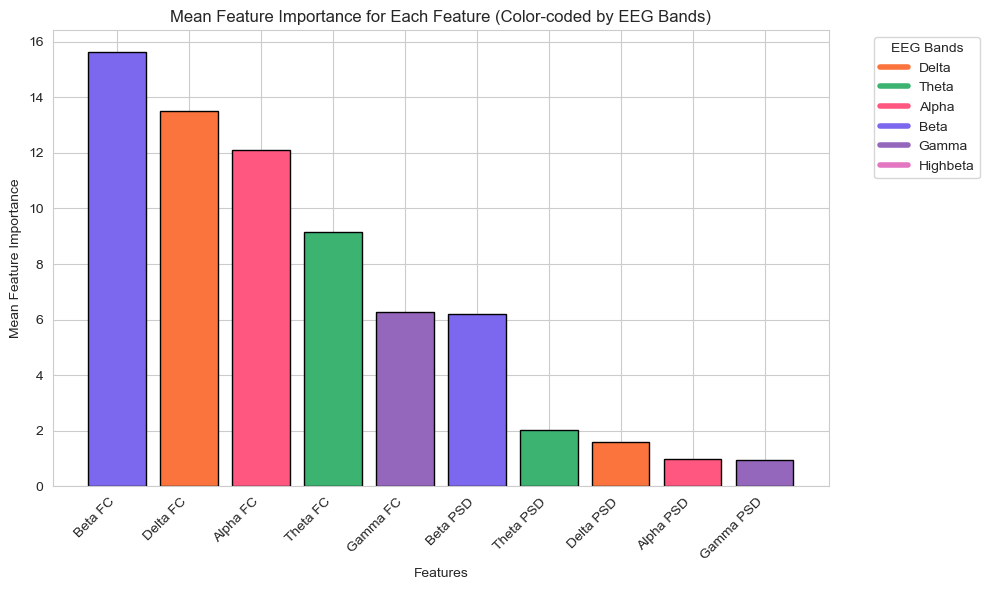

In [29]:
# Assigning colors based on EEG bands
band_colors = {
    'Delta': '#FB743E',    # vibrant blue
    'Theta': '#3cb371',    # vibrant green
    'Alpha': '#FF577F',    # vibrant orange
    'Beta': '#7b68ee',     # vibrant red
    'Gamma': '#9467bd',    # vibrant purple
    'Highbeta': '#e377c2'}

# Determining band for each feature and assigning color
colors = []
for feature in psd_fc_fi.index:
    found = False
    for band, color in band_colors.items():
        if band in feature:
            colors.append(color)
            found = True
            break
    if not found:
        colors.append('grey')


# Plotting the mean values with color coding based on EEG bands
plt.figure(figsize=(10, 6))
plt.bar(psd_fc_fi.index, psd_fc_fi['mean'], color=colors, edgecolor='black')
plt.xlabel('Features')
plt.ylabel('Mean Feature Importance')
plt.title('Mean Feature Importance for Each Feature (Color-coded by EEG Bands)')
plt.xticks(rotation=45, ha='right')


# Adding a legend for all EEG bands, even if not present in the data
legend_labels = [plt.Line2D([0], [0], color=color, lw=4) for color in band_colors.values()]
legend_titles = list(band_colors.keys())
plt.legend(legend_labels, legend_titles, title='EEG Bands', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [41]:
fi=importances.head(10)
print(fi)

                        split1_fi  split2_fi  split3_fi  split4_fi  split5_fi  \
AB.D.beta.m.T5           2.294962   1.558356   3.793390   1.049643   1.570553   
COH.A.delta.e.Fz.f.F4    1.086176   1.595528   0.595003   0.827789   0.324516   
COH.A.delta.c.F7.f.F4    0.539098   0.407278   1.327274   0.223714   0.235558   
COH.A.delta.o.Pz.r.O1    0.919912   0.494237   0.124700   1.164105   0.326967   
AB.D.beta.q.T6           0.374821   0.715316   0.775968   0.321389   0.320324   
COH.A.delta.i.C3.m.T5    1.559532   0.183929   0.107142   0.495486   0.418223   
COH.C.alpha.b.FP2.e.Fz   0.929630   0.268072   0.584624   0.744460   0.728741   
COH.C.alpha.a.FP1.e.Fz   0.371267   0.141177   0.279545   0.677594   0.963773   
COH.B.theta.e.Fz.f.F4    0.741918   0.406489   0.335992   0.985681   0.167253   
COH.C.alpha.a.FP1.n.P3   0.160073   0.939097   0.314552   0.294130   0.334080   

                        split6_fi  split7_fi  split8_fi  split9_fi  \
AB.D.beta.m.T5           2.189837   1.

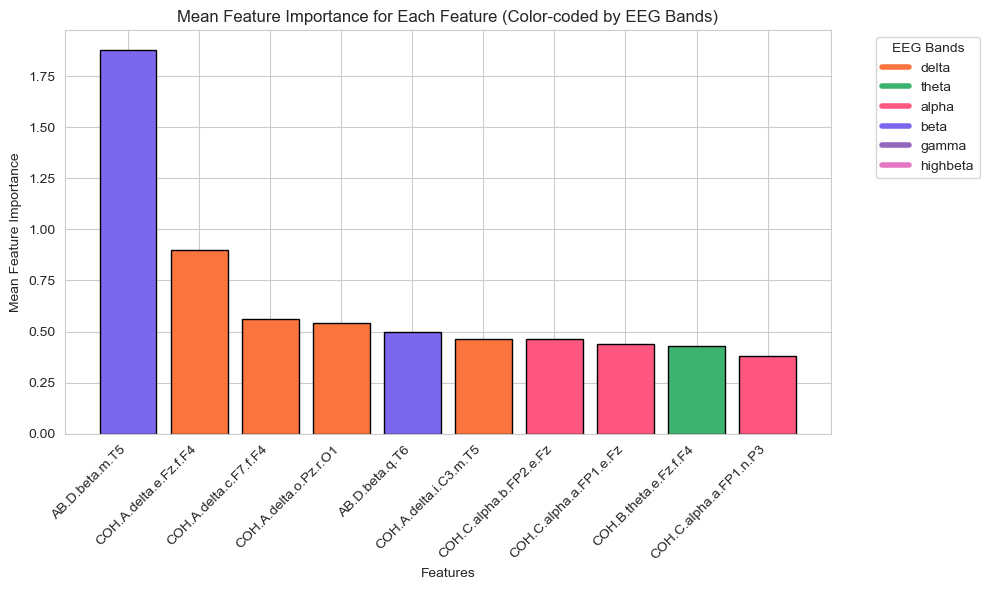

In [31]:

# Assigning colors based on EEG bands
band_colors = {
    'delta': '#FB743E',    # vibrant blue
    'theta': '#3cb371',    # vibrant green
    'alpha': '#FF577F',    # vibrant orange
    'beta': '#7b68ee',     # vibrant red
    'gamma': '#9467bd',    # vibrant purple
    'highbeta': '#e377c2'}

# Determining band for each feature and assigning color
colors = []
for feature in fi.index:
    found = False
    for band, color in band_colors.items():
        if band in feature:
            colors.append(color)
            found = True
            break
    if not found:
        colors.append('grey')


# Plotting the mean values with color coding based on EEG bands
plt.figure(figsize=(10, 6))
plt.bar(fi.index, fi['mean_fi'], color=colors, edgecolor='black')
plt.xlabel('Features')
plt.ylabel('Mean Feature Importance')
plt.title('Mean Feature Importance for Each Feature (Color-coded by EEG Bands)')
plt.xticks(rotation=45, ha='right')


# Adding a legend for all EEG bands, even if not present in the data
legend_labels = [plt.Line2D([0], [0], color=color, lw=4) for color in band_colors.values()]
legend_titles = list(band_colors.keys())
plt.legend(legend_labels, legend_titles, title='EEG Bands', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


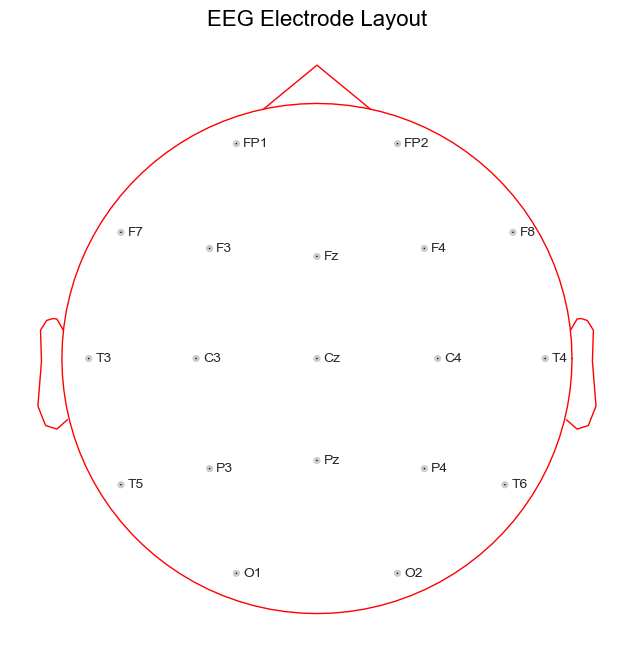

In [40]:
# Dictionary defining EEG electrode positions using the 10-20 system
# Keys are electrode names; values are [x, y] coordinates
chs = {
    'FP1': [-0.03, 0.08,0],
    'FP2': [0.03, 0.08,0],
    'F7': [-0.073, 0.047,0],
    'F3': [-0.04, 0.041,0],
    'Fz': [0, 0.038,0],
    'F4': [0.04, 0.041,0],
    'F8': [0.073, 0.047,0],
    'T3': [-0.085, 0,0],
    'C3': [-0.045, 0,0],
    'Cz': [0, 0,0],
    'C4': [0.045, 0,0],
    'T4': [0.085, 0,0],
    'T5': [-0.073, -0.047,0],
    'P3': [-0.04, -0.041,0],
    'Pz': [0, -0.038,0],
    'P4': [0.04, -0.041,0],
    'T6': [0.07, -0.047,0],
    'O1': [-0.03, -0.08,0],
    'O2': [0.03, -0.08,0]
}


# Create a digital montage from the 3D electrode positions
mont = mne.channels.make_dig_montage(chs)

# Plot the montage with color customization
fig = mont.plot(show=False)  # Set show=False to modify the figure before displaying

# Customize the plot using matplotlib
for ax in fig.get_axes():
    # Change the color of electrode points and labels
    for line in ax.get_lines():
        line.set_color('red')  # Change 'red' to your preferred color

plt.suptitle('EEG Electrode Layout', fontsize=16, color='black')  # Add a title for context
plt.show()


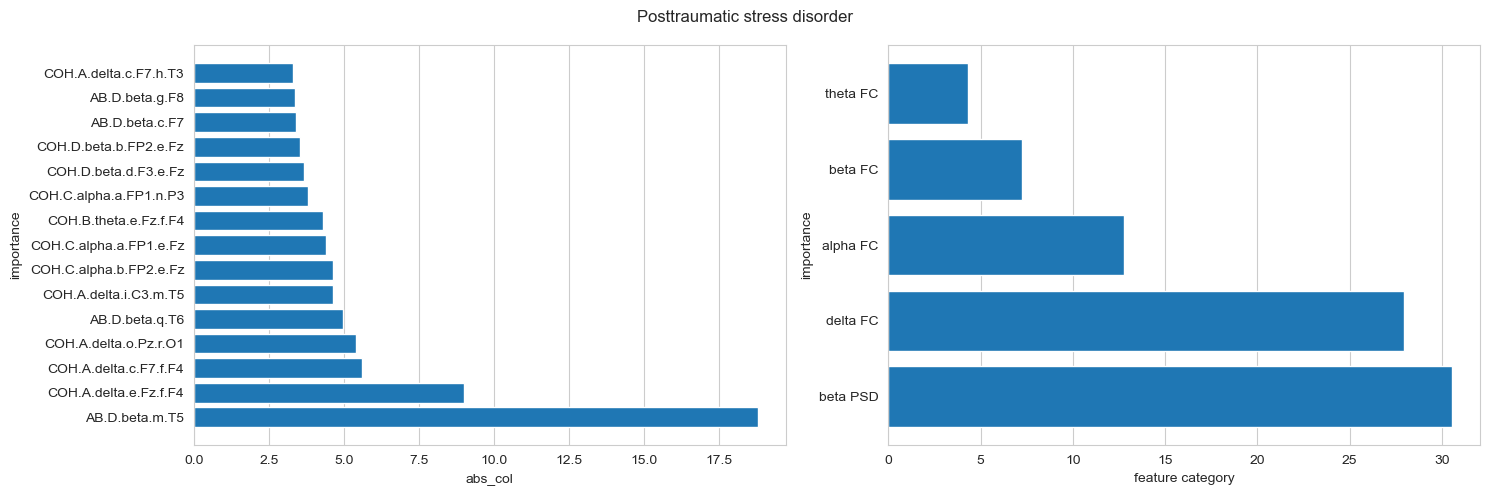

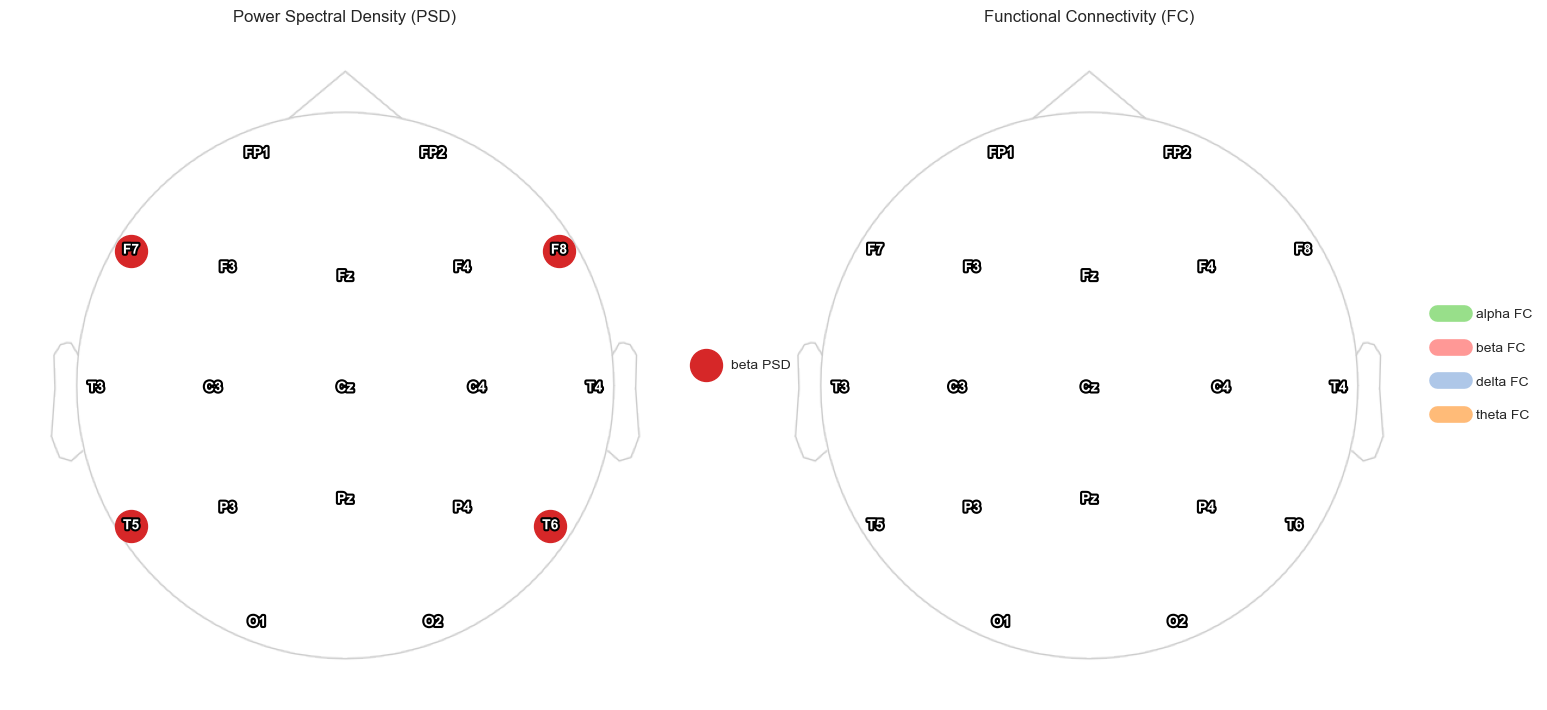

In [ ]:

fig1= report_fi(result, 'Posttraumatic stress disorder', 'abs_col')
plt.show()

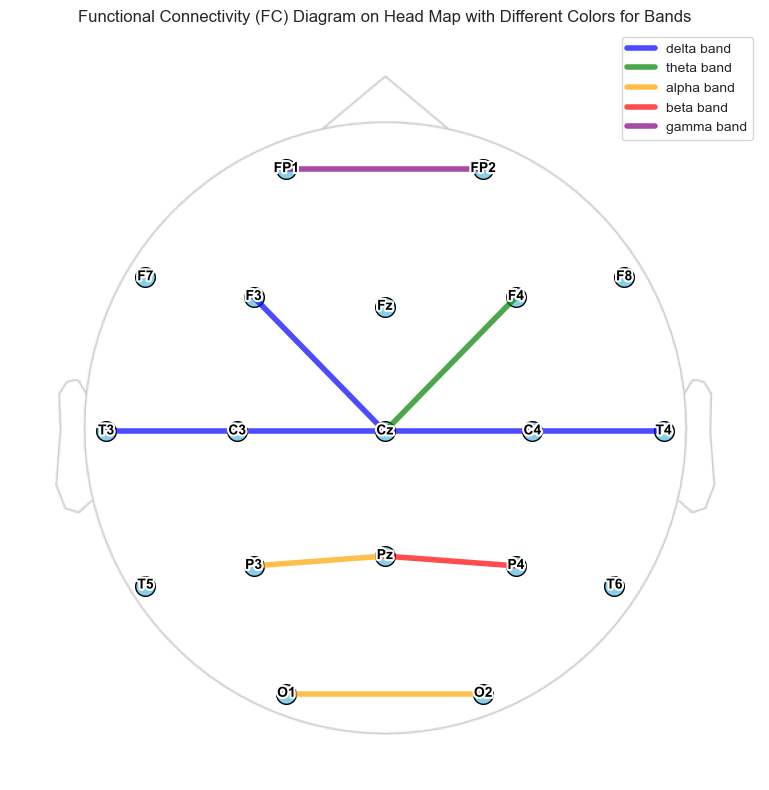

In [ ]:
# Generate FC diagram on a head map with different colors for different bands
fig, ax = plt.subplots(figsize=(8, 8))

# Load or create the head background image
try:
    im = plt.imread('head.png')
except FileNotFoundError:
    im = None
    print("Warning: Background image 'head.png' not found. Proceeding without it.")

# Plot the head background image
if im is not None:
    ax.imshow(im, extent=[-1, 1, -1, 1])

# Define color mapping for different bands
band_colors = {
    'delta': 'blue',
    'theta': 'green',
    'alpha': 'orange',
    'beta': 'red',
    'gamma': 'purple'
}

# Plot EEG channels
for name, coord in channels.iterrows():
    ax.scatter(coord[0], coord[1], s=200, c='skyblue', edgecolors='black')
    ax.text(coord[0], coord[1], name, color='black', fontsize=10, weight='bold',
            ha='center', va='center', path_effects=[PathEffects.withStroke(linewidth=3, foreground='white')])

# Sample FC connections with corresponding bands
fc_connections_bands = [
    ('F3', 'Cz', 'delta'),
    ('Cz', 'F4', 'theta'),
    ('P3', 'Pz', 'alpha'),
    ('Pz', 'P4', 'beta'),
    ('FP1', 'FP2', 'gamma'),
    ('T3', 'T4', 'delta'),
    ('O1', 'O2', 'alpha')
]

# Plot FC connections with different colors for different bands
for ch1, ch2, band in fc_connections_bands:
    if ch1 in channels.index and ch2 in channels.index:
        x_coords = [channels.loc[ch1, 0], channels.loc[ch2, 0]]
        y_coords = [channels.loc[ch1, 1], channels.loc[ch2, 1]]
        ax.plot(x_coords, y_coords, color=band_colors.get(band, 'grey'), linewidth=4, alpha=0.7, linestyle='-', label=f'{band} band')

# Avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper right', frameon=True)

# Set plot aesthetics
ax.set_title('Functional Connectivity (FC) Diagram on Head Map with Different Colors for Bands')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.axis('off')

plt.tight_layout()
plt.show()
